In [1]:
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
# import sklearn

In [243]:
df_train = pd.read_csv('labelled_training_data.csv')
df_valid = pd.read_csv('labelled_validation_data.csv')
df_test = pd.read_csv('labelled_testing_data.csv')

In [75]:
# want to include but not included:
# timestamp, processName(but it probably means the same to processId, and might miss categories), args

def preprocess(df):
    # Provided by BETH author (Highman 2021)
    df_preprocessed = pd.DataFrame(df[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'stackAddresses', 'returnValue']])

    # Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['processId'] = df['processId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # Parent Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['parentProcessId'] = df['parentProcessId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # User IDs: Map to 1 for users with IDs < 1000 (likely OS users), else 0
    df_preprocessed['userId'] = df['userId'].map(lambda x: 1 if x < 1000 else 0)  # Map to OS users

    # Namespace IDs: Check for specific value (402653184) for certain processes, else map to 0
    df_preprocessed['mountNamespace'] = df['mountNamespace'].map(lambda x: 0 if x == 402653184 else 1)  # Check for OS processes

    # Event IDs: Keep event IDs as is (assuming we need to know the maximum value) One-hot coding(?)
    df_preprocessed['eventId'] = df['eventId']

    # Convert the 'stackAddresses' string into a list of addresses
    df_preprocessed['stackAddresses'] = df['stackAddresses'].apply(lambda x: len(ast.literal_eval(x)) if x else 0)

    # Return Value: Map returnValue to 0 for 'failure', 1 for 'success', or 2 for unknown
    df_preprocessed['returnValue'] = df['returnValue'].map(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

    return df_preprocessed

In [77]:
X_train = preprocess(df_train)
X_valid = preprocess(df_valid)
X_test = preprocess(df_test)

In [78]:
y_train = df_train['evil']
y_valid = df_valid['evil']
y_test = df_test['evil']

1 Feature

In [17]:
clf_1 = IsolationForest(random_state = 10).fit(X_train[['processId']])

In [50]:
score_test = clf_1.decision_function(X_test[['processId']])
anomaly_test = clf_1.predict(X_test[['processId']])

In [52]:
df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

In [54]:
cm_1 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_1)

Confusion Matrix:
[[ 28465   2070]
 [158432      0]]


In [56]:
# classification_report for precision, recall, F1-score, and accuracy
report_1 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_1)

Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.15      0.93      0.26     30535
           1       0.00      0.00      0.00    158432

    accuracy                           0.15    188967
   macro avg       0.08      0.47      0.13    188967
weighted avg       0.02      0.15      0.04    188967



2 Features

In [58]:
clf_2 = IsolationForest(random_state = 10).fit(X_train[['processId', 'parentProcessId']])

score_test = clf_2.decision_function(X_test[['processId', 'parentProcessId']])
anomaly_test = clf_2.predict(X_test[['processId', 'parentProcessId']])

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_2 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_2)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_2 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_2)

Confusion Matrix:
[[ 21199   9336]
 [158414     18]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.12      0.69      0.20     30535
           1       0.00      0.00      0.00    158432

    accuracy                           0.11    188967
   macro avg       0.06      0.35      0.10    188967
weighted avg       0.02      0.11      0.03    188967



3 Features

In [238]:
clf_3 = IsolationForest(random_state = 10).fit(X_train[['processId', 'parentProcessId', 'userId']])

score_test = clf_3.decision_function(X_test[['processId', 'parentProcessId', 'userId']])
anomaly_test = clf_3.predict(X_test[['processId', 'parentProcessId', 'userId']])

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_3 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_3)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_3 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_3)

Confusion Matrix:
[[ 20953   9582]
 [  1137 157295]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     30535
           1       0.94      0.99      0.97    158432

    accuracy                           0.94    188967
   macro avg       0.95      0.84      0.88    188967
weighted avg       0.94      0.94      0.94    188967



ROC Curve for clf_3

ROC AUC score for Test Data: 0.31


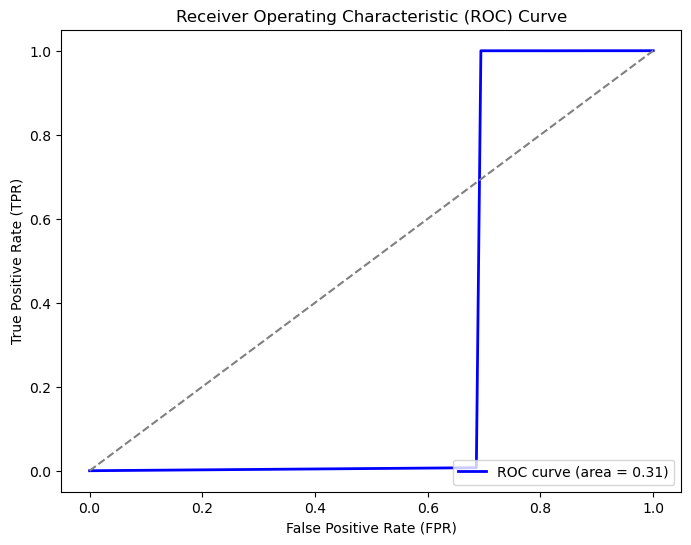

In [241]:
if len(np.unique(y_test)) > 1:  # Ensure there are at least two classes in y_test
    fpr, tpr, thresholds = roc_curve(y_test, score_test)  # Use the anomaly scores (not predictions)
    roc_auc = roc_auc_score(y_test, score_test)

    # Print the ROC AUC score
    print(f"ROC AUC score for Test Data: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    print("Error: Only one class present in the test data. Cannot compute ROC AUC.")

Hyperparameter tuning

In [218]:
# n_estimators does not make a difference
# max_samples 0.1~0.99 does not make a difference
# contamination does not improve the false positives
# changing the threshold looks like cheating, but I discovered there is a significant change if the threshold is set to arounf 0.0234

clf_3 = IsolationForest(random_state = 10).fit(X_train[['processId', 'parentProcessId', 'userId']])

score_test = clf_3.decision_function(X_test[['processId', 'parentProcessId', 'userId']])
anomaly_test = clf_3.predict(X_test[['processId', 'parentProcessId', 'userId']])

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_3 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_3)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_3 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_3)

Confusion Matrix:
[[ 20953   9582]
 [  1137 157295]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     30535
           1       0.94      0.99      0.97    158432

    accuracy                           0.94    188967
   macro avg       0.95      0.84      0.88    188967
weighted avg       0.94      0.94      0.94    188967



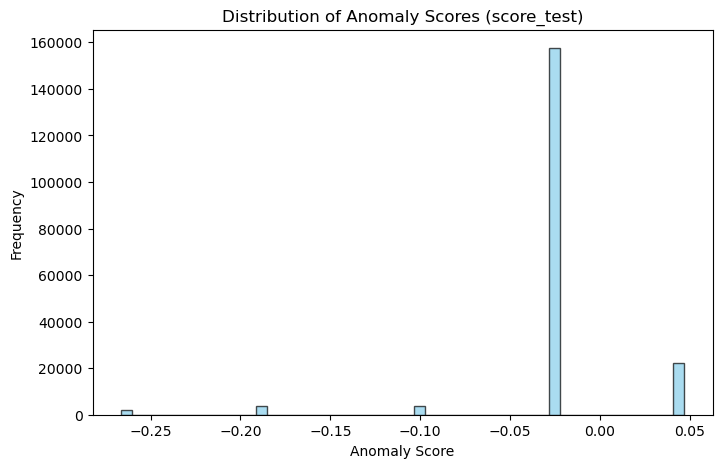

In [230]:
# Plotting the distribution of anomaly scores (score_test)
plt.figure(figsize=(8, 5))
plt.hist(score_test, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Adding labels and title
plt.title('Distribution of Anomaly Scores (score_test)')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

4 Features

In [91]:
clf_4 = IsolationForest(random_state = 10).fit(X_train[['processId', 'parentProcessId', 'userId', 'mountNamespace']])

score_test = clf_4.decision_function(X_test[['processId', 'parentProcessId', 'userId', 'mountNamespace']])
anomaly_test = clf_4.predict(X_test[['processId', 'parentProcessId', 'userId', 'mountNamespace']])

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_4 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_4)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_4 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_4)

Confusion Matrix:
[[ 20953   9582]
 [  1137 157295]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     30535
           1       0.94      0.99      0.97    158432

    accuracy                           0.94    188967
   macro avg       0.95      0.84      0.88    188967
weighted avg       0.94      0.94      0.94    188967



ROC AUC score for Test Data: 0.31


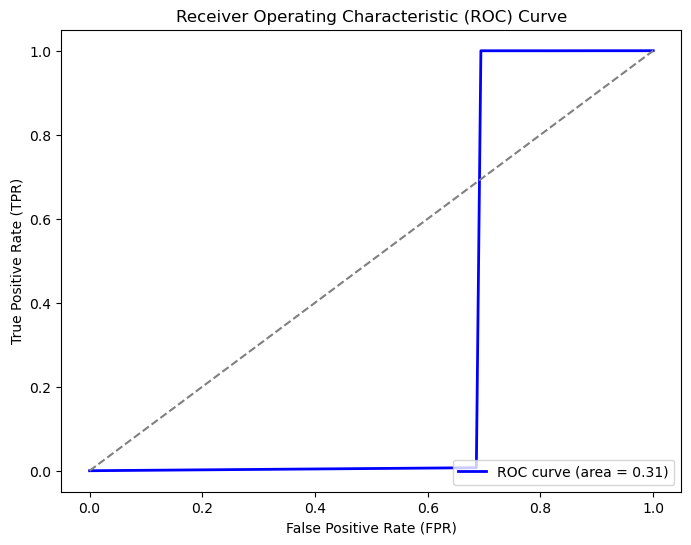

In [93]:
if len(np.unique(y_test)) > 1:
    # Compute ROC curve and ROC AUC score for test set
    fpr, tpr, thresholds = roc_curve(y_test, score_test)
    roc_auc = roc_auc_score(y_test, score_test)

    # Print the ROC AUC score
    print(f"ROC AUC score for Test Data: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    print("Error: Only one class present in the test data. Cannot compute ROC AUC.")

5 Features

In [97]:
clf_5 = IsolationForest(random_state = 10).fit(X_train[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId']])

score_test = clf_5.decision_function(X_test[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId']])
anomaly_test = clf_5.predict(X_test[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId']])

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_5 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_5)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_5 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_5)

Confusion Matrix:
[[ 19566  10969]
 [  6154 152278]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.76      0.64      0.70     30535
           1       0.93      0.96      0.95    158432

    accuracy                           0.91    188967
   macro avg       0.85      0.80      0.82    188967
weighted avg       0.91      0.91      0.91    188967



ROC AUC score for Test Data: 0.23


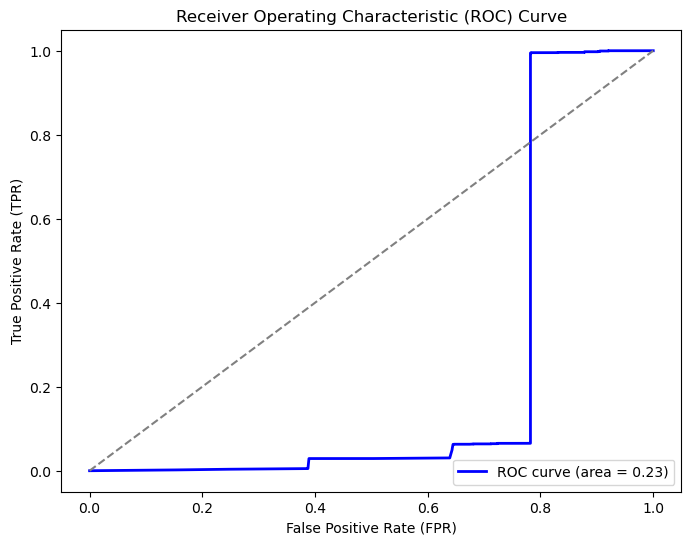

In [99]:
if len(np.unique(y_test)) > 1:
    # Compute ROC curve and ROC AUC score for test set
    fpr, tpr, thresholds = roc_curve(y_test, score_test)
    roc_auc = roc_auc_score(y_test, score_test)

    # Print the ROC AUC score
    print(f"ROC AUC score for Test Data: {roc_auc:.2f}")

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

else:
    print("Error: Only one class present in the test data. Cannot compute ROC AUC.")

6 Features

In [81]:
clf_6 = IsolationForest(random_state = 10).fit(X_train[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'stackAddresses']])

score_test = clf_6.decision_function(X_test[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'stackAddresses']])
anomaly_test = clf_6.predict(X_test[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'stackAddresses']])

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_6 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_6)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_6 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_6)

Confusion Matrix:
[[ 19406  11129]
 [  9495 148937]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65     30535
           1       0.93      0.94      0.94    158432

    accuracy                           0.89    188967
   macro avg       0.80      0.79      0.79    188967
weighted avg       0.89      0.89      0.89    188967



7 Features

In [84]:
clf_7 = IsolationForest(random_state = 10).fit(X_train)

score_test = clf_7.decision_function(X_test)
anomaly_test = clf_7.predict(X_test)

df_anomaly_test = pd.DataFrame({'anomaly': anomaly_test})
df_anomaly_test['anomaly'] = df_anomaly_test['anomaly'].apply(lambda x: 1 if x == -1 else 0)

cm_7 = confusion_matrix(y_test, df_anomaly_test['anomaly'])
print("Confusion Matrix:")
print(cm_7)

print("\n")

# classification_report for precision, recall, F1-score, and accuracy
report_7 = classification_report(y_test, df_anomaly_test['anomaly'])
print("Classification Report on Testing Data:")
print(report_7)

Confusion Matrix:
[[ 18856  11679]
 [  9235 149197]]


Classification Report on Testing Data:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64     30535
           1       0.93      0.94      0.93    158432

    accuracy                           0.89    188967
   macro avg       0.80      0.78      0.79    188967
weighted avg       0.89      0.89      0.89    188967

